# Applying Autoencoders to DNA Methylation data from TCGA (MLB Lab) ( 390,000-> AE(39,000-> 100\*23 -> 500 -> 100 ->500-> 100\*23 -> 39,000)

In [ ]:
# EPOCH = 100
# BATCH_SIZE = 32
# NUM_FOLDS = 10

# # detect and init the TPU
# #tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# #tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# # GET GPU STRATEGY
# gpu_strategy = tf.distribute.get_strategy()

# with gpu_strategy.scope():
#     kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
#     test_preds = []
#     for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
#         K.clear_session()
        
#         print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
#         X_train, X_valid = train[train_idx], train[test_idx]
#         y_train, y_valid = targets[train_idx], targets[test_idx]
        
#         checkpoint_filepath = f"folds{fold}.hdf5"
#         if TRAIN_MODEL:
# #             model = keras.models.Sequential([
# #                 keras.layers.Input(shape=train.shape[-2:]),
# #                 keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True)),
# #                 keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)),
# #                 keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
# #                 keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
# #                 keras.layers.Dense(128, activation='selu'),
# #                 keras.layers.Dense(1),
# #             ])
            
#             n_output_nodes = 2
#             lstm_nodes = 64
#             dense_1_nodes = 32
#             optimizer = 'adam'
#             loss_fn = root_mean_squared_error

#             model = Sequential()
#             model.add(Bidirectional(LSTM(lstm_nodes, activation='relu', dropout=0.2), input_shape=(X_train.shape[1],X_train.shape[2])))
#             # model.add(LSTM(128,  activation='relu', return_sequences=True))
#             model.add(Dense(dense_1_nodes, activation="selu"))
#             model.add(Dense(n_output_nodes)) 
#             model.compile(loss=loss_fn, optimizer=optimizer,metrics = [loss_fn])
#             model.summary()
#             model.compile(optimizer="adam", loss="mae")
#             checkpoint_filepath = "vanillalstm"
            
#             lr = ReduceLROnPlateau(monitor='val_loss',patience=20, verbose=1, factor=0.5, min_lr=1e-10)
#             es = EarlyStopping(monitor="val_loss", patience=20, verbose=1, mode="min", restore_best_weights=True)
#             sv = ModelCheckpoint(
#                 checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
#                 save_weights_only=False, mode='auto', save_freq='epoch',
#                 options=None
#             )
#             model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es, sv])
#             model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=100, batch_size=16,  verbose=1, shuffle=False, callbacks=[lr,sv])
#         else:
#             model = keras.models.load_model('../input/finetune-of-tensorflow-bidirectional-lstm/'+checkpoint_filepath)

#         if INFER_TEST:
#             print(' Predicting test data...')
#             test_preds.append(model.predict(reshape_data(x_test, timesteps=1)))

In [1]:
import joblib
import pandas as pd

meth_df_path =  "pancancer_meth_top10percent_chr_nonna_fillnamean.pkl"
pancancer_meth_list = joblib.load(meth_df_path)
len(pancancer_meth_list)

23

In [3]:
# mv_pancancer_meth_list = []
# for df in pancancer_meth_list:
#     no_features = int(df.shape[1]/2)
#     most_variable_genes = df.mad(axis = 0).nlargest(no_features, keep='all').index.values.tolist()
#     #Subseting the genes from mvg_v3_df that are on the most_variable_genes list
#     mvf_df = df[most_variable_genes]
#     mv_pancancer_meth_list.append(mvf_df)
# len(mv_pancancer_meth_list)

# # ## Saving the list of chromosome dataframe
# # joblib.dump(mv_pancancer_meth_list, "pancancer_meth_top10percent_chr_nonna_fillnamean.pkl")

23

In [2]:
for chro in pancancer_meth_list:
    print(chro.shape)

(9756, 3813)
(9756, 1978)
(9756, 2367)
(9756, 1987)
(9756, 974)
(9756, 1239)
(9756, 1249)
(9756, 1802)
(9756, 2347)
(9756, 500)
(9756, 2106)
(9756, 2814)
(9756, 870)
(9756, 322)
(9756, 699)
(9756, 2016)
(9756, 1599)
(9756, 1967)
(9756, 2926)
(9756, 2407)
(9756, 1651)
(9756, 806)
(9756, 975)


### 5. Building a Vanilla Autoencoder

In [3]:
import tensorflow as tf
# print(tf.__version__)
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from numpy.random import seed
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras import backend as K #For explicitly \adjusting the learning rate

In [86]:
from numpy.random import seed
seed(1)

tf.random.set_seed(2)


In [5]:
X_train, X_val = train_test_split(pancancer_meth_list[0], test_size=0.2, random_state = seed(77))
#Since the samples will be split similarly across all chromosomes, we shall match the indices for 
# X_train and X_val across all chr
training_indices = X_train.index
validation_indices = X_val.index

X_train_list = []
X_val_list = []
for chrom_df in pancancer_meth_list:
    X_train_list.append(chrom_df.loc[training_indices])
    X_val_list.append(chrom_df.loc[validation_indices])

In [6]:
tf.keras.backend.clear_session()
ncol_list = []
for df in pancancer_meth_list:
    ncol_list.append(df.shape[1])
    
number_of_chromosomes = len(pancancer_meth_list)

chromsomome_dim = 100 # 100*23
hidden_layer_dim = 500 
encoding_dim = 100 #Nodes in Bottleneck layer

# Encoder Layers
encoded1_list = []
input_dim_list = []
for ncol in ncol_list:
    input_dim_i = Input(shape = (ncol, ))
    input_dim_list.append(input_dim_i)
    encoded1_i = Dense(chromsomome_dim, activation = 'relu')(input_dim_i)
#     input_model = Model(inputs=input_dim_i, outputs=encoded1_i)
    encoded1_list.append(encoded1_i)

# encoded1 = concatenate(encoded1_list)
encoded1 = Concatenate(axis=1)(encoded1_list)
encoded2 = Dense(hidden_layer_dim, activation = 'relu')(encoded1)
encoded3 = Dense(encoding_dim, activation = 'relu')(encoded2)

# Decoder Layers
decoded3 = Dense(hidden_layer_dim, activation = 'relu')(encoded3)
decoded2 = Dense(chromsomome_dim*number_of_chromosomes, activation = 'relu')(decoded3)
reconstructured_inputs = []
for i in range(0,number_of_chromosomes):
    start = chromsomome_dim*(i)
    end = chromsomome_dim*(i+1)
    decoded2_i = decoded2[:,start:end] #Splicing the tensor back to chromsomome_dim*23 tensors
    decoded1_i = Dense(ncol_list[i], activation = 'sigmoid')(decoded2_i)
#     output_model = Model(inputs=decoded2_i, outputs=decoded1_i)
#     reconstructured_inputs.append(output_model.output)
    reconstructured_inputs.append(decoded1_i)
    
autoencoder = Model(inputs = input_dim_list, outputs = reconstructured_inputs)

In [7]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3813)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1978)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2367)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1987)]       0           []                               
                                                                                              

 dense_17 (Dense)               (None, 100)          196800      ['input_18[0][0]']               
                                                                                                  
 dense_18 (Dense)               (None, 100)          292700      ['input_19[0][0]']               
                                                                                                  
 dense_19 (Dense)               (None, 100)          240800      ['input_20[0][0]']               
                                                                                                  
 dense_20 (Dense)               (None, 100)          165200      ['input_21[0][0]']               
                                                                                                  
 dense_21 (Dense)               (None, 100)          80700       ['input_22[0][0]']               
                                                                                                  
 dense_22 

 tf.__operators__.getitem_13 (S  (None, 100)         0           ['dense_26[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_14 (S  (None, 100)         0           ['dense_26[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_15 (S  (None, 100)         0           ['dense_26[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_16 (S  (None, 100)         0           ['dense_26[0][0]']               
 licingOpL

                                                                                                  
 dense_45 (Dense)               (None, 2926)         295526      ['tf.__operators__.getitem_18[0][
                                                                 0]']                             
                                                                                                  
 dense_46 (Dense)               (None, 2407)         243107      ['tf.__operators__.getitem_19[0][
                                                                 0]']                             
                                                                                                  
 dense_47 (Dense)               (None, 1651)         166751      ['tf.__operators__.getitem_20[0][
                                                                 0]']                             
                                                                                                  
 dense_48 

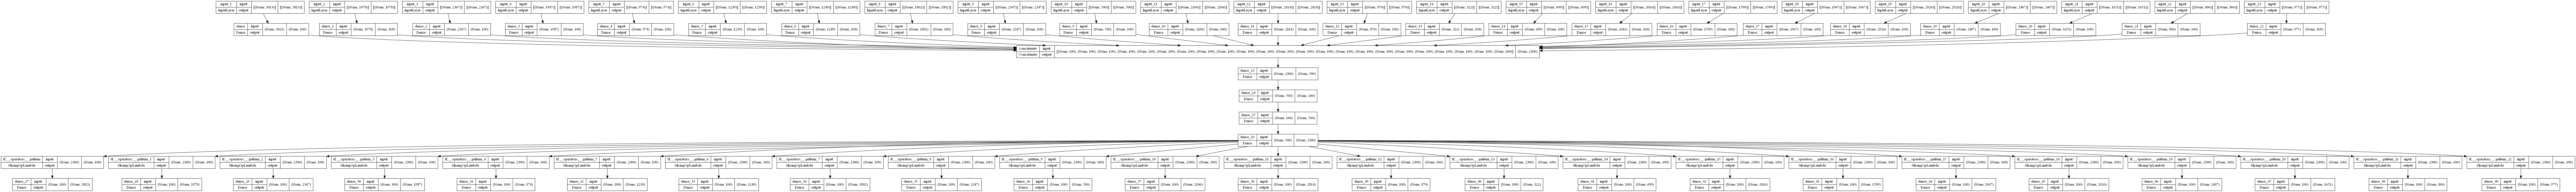

In [8]:
#Plotting the model
# !pip install pydot
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, show_shapes=True, show_layer_names=True) #to_file='model_plot.png', )

In [9]:
#MODEL Parameters
def averaged_mean_squared_error(y_true, y_pred):
        return (K.sqrt(K.mean(K.square(y_pred - y_true))))/number_of_chromosomes

# Compile the Model
autoencoder.compile(optimizer = 'adam', loss = averaged_mean_squared_error) 

#adam - stochastic gradient descent algorithm

# K.set_value(autoencoder.optimizer.learning_rate, 0.0001)


In [10]:
#Implementing Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import datetime

learning_rate = ReduceLROnPlateau(monitor='val_loss',patience=20, verbose=1, factor=0.5, min_lr=1e-10)

# earlystopping_callback = EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# import h5py
# !pip install --upgrade h5py=1.8.21
# #Saving best Model after the Stopping
# mc = ModelCheckpoint('meth_ae_v1.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [11]:
print(log_dir)

logs/fit/20220412-230255


In [12]:
history = autoencoder.fit(X_train_list, X_train_list, epochs = 100, batch_size = 16, shuffle = False, verbose = 1, validation_data = (X_val_list, X_val_list), callbacks=[learning_rate,tensorboard_callback])

Epoch 1/100
488/488 [==============================] - 29s 50ms/step - loss: 0.1976 - dense_27_loss: 0.0086 - dense_28_loss: 0.0087 - dense_29_loss: 0.0085 - dense_30_loss: 0.0088 - dense_31_loss: 0.0088 - dense_32_loss: 0.0085 - dense_33_loss: 0.0086 - dense_34_loss: 0.0086 - dense_35_loss: 0.0087 - dense_36_loss: 0.0085 - dense_37_loss: 0.0085 - dense_38_loss: 0.0088 - dense_39_loss: 0.0085 - dense_40_loss: 0.0087 - dense_41_loss: 0.0084 - dense_42_loss: 0.0087 - dense_43_loss: 0.0087 - dense_44_loss: 0.0088 - dense_45_loss: 0.0088 - dense_46_loss: 0.0089 - dense_47_loss: 0.0088 - dense_48_loss: 0.0085 - dense_49_loss: 0.0072 - val_loss: 0.1665 - val_dense_27_loss: 0.0072 - val_dense_28_loss: 0.0073 - val_dense_29_loss: 0.0071 - val_dense_30_loss: 0.0074 - val_dense_31_loss: 0.0074 - val_dense_32_loss: 0.0072 - val_dense_33_loss: 0.0072 - val_dense_34_loss: 0.0072 - val_dense_35_loss: 0.0073 - val_dense_36_loss: 0.0072 - val_dense_37_loss: 0.0072 - val_dense_38_loss: 0.0074 - val_den

488/488 [==============================] - 22s 44ms/step - loss: 0.1465 - dense_27_loss: 0.0063 - dense_28_loss: 0.0064 - dense_29_loss: 0.0063 - dense_30_loss: 0.0064 - dense_31_loss: 0.0065 - dense_32_loss: 0.0063 - dense_33_loss: 0.0063 - dense_34_loss: 0.0063 - dense_35_loss: 0.0064 - dense_36_loss: 0.0064 - dense_37_loss: 0.0064 - dense_38_loss: 0.0064 - dense_39_loss: 0.0063 - dense_40_loss: 0.0065 - dense_41_loss: 0.0062 - dense_42_loss: 0.0064 - dense_43_loss: 0.0064 - dense_44_loss: 0.0066 - dense_45_loss: 0.0066 - dense_46_loss: 0.0065 - dense_47_loss: 0.0065 - dense_48_loss: 0.0063 - dense_49_loss: 0.0056 - val_loss: 0.1465 - val_dense_27_loss: 0.0063 - val_dense_28_loss: 0.0064 - val_dense_29_loss: 0.0063 - val_dense_30_loss: 0.0064 - val_dense_31_loss: 0.0065 - val_dense_32_loss: 0.0063 - val_dense_33_loss: 0.0063 - val_dense_34_loss: 0.0063 - val_dense_35_loss: 0.0064 - val_dense_36_loss: 0.0064 - val_dense_37_loss: 0.0065 - val_dense_38_loss: 0.0064 - val_dense_39_loss: 

488/488 [==============================] - 21s 44ms/step - loss: 0.1416 - dense_27_loss: 0.0061 - dense_28_loss: 0.0062 - dense_29_loss: 0.0060 - dense_30_loss: 0.0062 - dense_31_loss: 0.0063 - dense_32_loss: 0.0061 - dense_33_loss: 0.0061 - dense_34_loss: 0.0060 - dense_35_loss: 0.0062 - dense_36_loss: 0.0062 - dense_37_loss: 0.0062 - dense_38_loss: 0.0062 - dense_39_loss: 0.0061 - dense_40_loss: 0.0062 - dense_41_loss: 0.0060 - dense_42_loss: 0.0062 - dense_43_loss: 0.0062 - dense_44_loss: 0.0064 - dense_45_loss: 0.0064 - dense_46_loss: 0.0063 - dense_47_loss: 0.0063 - dense_48_loss: 0.0061 - dense_49_loss: 0.0055 - val_loss: 0.1427 - val_dense_27_loss: 0.0062 - val_dense_28_loss: 0.0062 - val_dense_29_loss: 0.0061 - val_dense_30_loss: 0.0063 - val_dense_31_loss: 0.0063 - val_dense_32_loss: 0.0062 - val_dense_33_loss: 0.0062 - val_dense_34_loss: 0.0061 - val_dense_35_loss: 0.0062 - val_dense_36_loss: 0.0063 - val_dense_37_loss: 0.0063 - val_dense_38_loss: 0.0063 - val_dense_39_loss: 

488/488 [==============================] - 21s 44ms/step - loss: 0.1401 - dense_27_loss: 0.0061 - dense_28_loss: 0.0061 - dense_29_loss: 0.0060 - dense_30_loss: 0.0062 - dense_31_loss: 0.0062 - dense_32_loss: 0.0061 - dense_33_loss: 0.0060 - dense_34_loss: 0.0060 - dense_35_loss: 0.0061 - dense_36_loss: 0.0061 - dense_37_loss: 0.0062 - dense_38_loss: 0.0062 - dense_39_loss: 0.0060 - dense_40_loss: 0.0061 - dense_41_loss: 0.0059 - dense_42_loss: 0.0062 - dense_43_loss: 0.0062 - dense_44_loss: 0.0063 - dense_45_loss: 0.0063 - dense_46_loss: 0.0063 - dense_47_loss: 0.0062 - dense_48_loss: 0.0060 - dense_49_loss: 0.0054 - val_loss: 0.1413 - val_dense_27_loss: 0.0061 - val_dense_28_loss: 0.0062 - val_dense_29_loss: 0.0060 - val_dense_30_loss: 0.0062 - val_dense_31_loss: 0.0063 - val_dense_32_loss: 0.0061 - val_dense_33_loss: 0.0061 - val_dense_34_loss: 0.0060 - val_dense_35_loss: 0.0061 - val_dense_36_loss: 0.0062 - val_dense_37_loss: 0.0063 - val_dense_38_loss: 0.0062 - val_dense_39_loss: 

488/488 [==============================] - 22s 44ms/step - loss: 0.1391 - dense_27_loss: 0.0060 - dense_28_loss: 0.0061 - dense_29_loss: 0.0059 - dense_30_loss: 0.0061 - dense_31_loss: 0.0062 - dense_32_loss: 0.0060 - dense_33_loss: 0.0060 - dense_34_loss: 0.0059 - dense_35_loss: 0.0061 - dense_36_loss: 0.0061 - dense_37_loss: 0.0061 - dense_38_loss: 0.0061 - dense_39_loss: 0.0060 - dense_40_loss: 0.0061 - dense_41_loss: 0.0059 - dense_42_loss: 0.0061 - dense_43_loss: 0.0061 - dense_44_loss: 0.0063 - dense_45_loss: 0.0062 - dense_46_loss: 0.0062 - dense_47_loss: 0.0062 - dense_48_loss: 0.0060 - dense_49_loss: 0.0054 - val_loss: 0.1416 - val_dense_27_loss: 0.0061 - val_dense_28_loss: 0.0062 - val_dense_29_loss: 0.0060 - val_dense_30_loss: 0.0062 - val_dense_31_loss: 0.0063 - val_dense_32_loss: 0.0061 - val_dense_33_loss: 0.0061 - val_dense_34_loss: 0.0061 - val_dense_35_loss: 0.0062 - val_dense_36_loss: 0.0062 - val_dense_37_loss: 0.0063 - val_dense_38_loss: 0.0062 - val_dense_39_loss: 

488/488 [==============================] - 21s 44ms/step - loss: 0.1382 - dense_27_loss: 0.0060 - dense_28_loss: 0.0061 - dense_29_loss: 0.0059 - dense_30_loss: 0.0061 - dense_31_loss: 0.0061 - dense_32_loss: 0.0060 - dense_33_loss: 0.0060 - dense_34_loss: 0.0059 - dense_35_loss: 0.0060 - dense_36_loss: 0.0060 - dense_37_loss: 0.0061 - dense_38_loss: 0.0061 - dense_39_loss: 0.0060 - dense_40_loss: 0.0060 - dense_41_loss: 0.0058 - dense_42_loss: 0.0061 - dense_43_loss: 0.0061 - dense_44_loss: 0.0062 - dense_45_loss: 0.0062 - dense_46_loss: 0.0062 - dense_47_loss: 0.0061 - dense_48_loss: 0.0059 - dense_49_loss: 0.0054 - val_loss: 0.1396 - val_dense_27_loss: 0.0060 - val_dense_28_loss: 0.0061 - val_dense_29_loss: 0.0059 - val_dense_30_loss: 0.0061 - val_dense_31_loss: 0.0062 - val_dense_32_loss: 0.0060 - val_dense_33_loss: 0.0060 - val_dense_34_loss: 0.0060 - val_dense_35_loss: 0.0061 - val_dense_36_loss: 0.0061 - val_dense_37_loss: 0.0062 - val_dense_38_loss: 0.0061 - val_dense_39_loss: 

488/488 [==============================] - 22s 44ms/step - loss: 0.1381 - dense_27_loss: 0.0060 - dense_28_loss: 0.0060 - dense_29_loss: 0.0059 - dense_30_loss: 0.0061 - dense_31_loss: 0.0061 - dense_32_loss: 0.0060 - dense_33_loss: 0.0060 - dense_34_loss: 0.0059 - dense_35_loss: 0.0060 - dense_36_loss: 0.0060 - dense_37_loss: 0.0061 - dense_38_loss: 0.0061 - dense_39_loss: 0.0060 - dense_40_loss: 0.0060 - dense_41_loss: 0.0058 - dense_42_loss: 0.0061 - dense_43_loss: 0.0061 - dense_44_loss: 0.0062 - dense_45_loss: 0.0062 - dense_46_loss: 0.0062 - dense_47_loss: 0.0061 - dense_48_loss: 0.0059 - dense_49_loss: 0.0053 - val_loss: 0.1413 - val_dense_27_loss: 0.0061 - val_dense_28_loss: 0.0062 - val_dense_29_loss: 0.0060 - val_dense_30_loss: 0.0062 - val_dense_31_loss: 0.0063 - val_dense_32_loss: 0.0061 - val_dense_33_loss: 0.0061 - val_dense_34_loss: 0.0061 - val_dense_35_loss: 0.0061 - val_dense_36_loss: 0.0062 - val_dense_37_loss: 0.0063 - val_dense_38_loss: 0.0062 - val_dense_39_loss: 

488/488 [==============================] - 21s 44ms/step - loss: 0.1368 - dense_27_loss: 0.0059 - dense_28_loss: 0.0060 - dense_29_loss: 0.0058 - dense_30_loss: 0.0060 - dense_31_loss: 0.0061 - dense_32_loss: 0.0059 - dense_33_loss: 0.0059 - dense_34_loss: 0.0058 - dense_35_loss: 0.0060 - dense_36_loss: 0.0060 - dense_37_loss: 0.0060 - dense_38_loss: 0.0060 - dense_39_loss: 0.0059 - dense_40_loss: 0.0059 - dense_41_loss: 0.0058 - dense_42_loss: 0.0060 - dense_43_loss: 0.0060 - dense_44_loss: 0.0062 - dense_45_loss: 0.0062 - dense_46_loss: 0.0061 - dense_47_loss: 0.0061 - dense_48_loss: 0.0059 - dense_49_loss: 0.0053 - val_loss: 0.1394 - val_dense_27_loss: 0.0060 - val_dense_28_loss: 0.0061 - val_dense_29_loss: 0.0059 - val_dense_30_loss: 0.0061 - val_dense_31_loss: 0.0062 - val_dense_32_loss: 0.0060 - val_dense_33_loss: 0.0060 - val_dense_34_loss: 0.0060 - val_dense_35_loss: 0.0061 - val_dense_36_loss: 0.0061 - val_dense_37_loss: 0.0062 - val_dense_38_loss: 0.0061 - val_dense_39_loss: 

488/488 [==============================] - 22s 45ms/step - loss: 0.1367 - dense_27_loss: 0.0059 - dense_28_loss: 0.0060 - dense_29_loss: 0.0058 - dense_30_loss: 0.0060 - dense_31_loss: 0.0061 - dense_32_loss: 0.0059 - dense_33_loss: 0.0059 - dense_34_loss: 0.0058 - dense_35_loss: 0.0060 - dense_36_loss: 0.0060 - dense_37_loss: 0.0060 - dense_38_loss: 0.0060 - dense_39_loss: 0.0059 - dense_40_loss: 0.0059 - dense_41_loss: 0.0058 - dense_42_loss: 0.0060 - dense_43_loss: 0.0060 - dense_44_loss: 0.0062 - dense_45_loss: 0.0061 - dense_46_loss: 0.0061 - dense_47_loss: 0.0061 - dense_48_loss: 0.0059 - dense_49_loss: 0.0053 - val_loss: 0.1398 - val_dense_27_loss: 0.0060 - val_dense_28_loss: 0.0061 - val_dense_29_loss: 0.0060 - val_dense_30_loss: 0.0061 - val_dense_31_loss: 0.0062 - val_dense_32_loss: 0.0060 - val_dense_33_loss: 0.0060 - val_dense_34_loss: 0.0060 - val_dense_35_loss: 0.0061 - val_dense_36_loss: 0.0061 - val_dense_37_loss: 0.0062 - val_dense_38_loss: 0.0061 - val_dense_39_loss: 

488/488 [==============================] - 22s 45ms/step - loss: 0.1364 - dense_27_loss: 0.0059 - dense_28_loss: 0.0060 - dense_29_loss: 0.0058 - dense_30_loss: 0.0060 - dense_31_loss: 0.0060 - dense_32_loss: 0.0059 - dense_33_loss: 0.0059 - dense_34_loss: 0.0058 - dense_35_loss: 0.0059 - dense_36_loss: 0.0059 - dense_37_loss: 0.0060 - dense_38_loss: 0.0060 - dense_39_loss: 0.0059 - dense_40_loss: 0.0059 - dense_41_loss: 0.0058 - dense_42_loss: 0.0060 - dense_43_loss: 0.0060 - dense_44_loss: 0.0062 - dense_45_loss: 0.0061 - dense_46_loss: 0.0061 - dense_47_loss: 0.0061 - dense_48_loss: 0.0059 - dense_49_loss: 0.0053 - val_loss: 0.1405 - val_dense_27_loss: 0.0060 - val_dense_28_loss: 0.0061 - val_dense_29_loss: 0.0060 - val_dense_30_loss: 0.0062 - val_dense_31_loss: 0.0062 - val_dense_32_loss: 0.0061 - val_dense_33_loss: 0.0061 - val_dense_34_loss: 0.0060 - val_dense_35_loss: 0.0061 - val_dense_36_loss: 0.0062 - val_dense_37_loss: 0.0062 - val_dense_38_loss: 0.0062 - val_dense_39_loss: 

488/488 [==============================] - 22s 44ms/step - loss: 0.1355 - dense_27_loss: 0.0058 - dense_28_loss: 0.0059 - dense_29_loss: 0.0058 - dense_30_loss: 0.0060 - dense_31_loss: 0.0060 - dense_32_loss: 0.0059 - dense_33_loss: 0.0058 - dense_34_loss: 0.0058 - dense_35_loss: 0.0059 - dense_36_loss: 0.0059 - dense_37_loss: 0.0060 - dense_38_loss: 0.0060 - dense_39_loss: 0.0058 - dense_40_loss: 0.0059 - dense_41_loss: 0.0057 - dense_42_loss: 0.0060 - dense_43_loss: 0.0060 - dense_44_loss: 0.0061 - dense_45_loss: 0.0061 - dense_46_loss: 0.0060 - dense_47_loss: 0.0060 - dense_48_loss: 0.0058 - dense_49_loss: 0.0053 - val_loss: 0.1394 - val_dense_27_loss: 0.0060 - val_dense_28_loss: 0.0061 - val_dense_29_loss: 0.0060 - val_dense_30_loss: 0.0061 - val_dense_31_loss: 0.0062 - val_dense_32_loss: 0.0060 - val_dense_33_loss: 0.0060 - val_dense_34_loss: 0.0059 - val_dense_35_loss: 0.0061 - val_dense_36_loss: 0.0061 - val_dense_37_loss: 0.0062 - val_dense_38_loss: 0.0061 - val_dense_39_loss: 

Epoch 67/100
488/488 [==============================] - 22s 45ms/step - loss: 0.1337 - dense_27_loss: 0.0058 - dense_28_loss: 0.0059 - dense_29_loss: 0.0057 - dense_30_loss: 0.0059 - dense_31_loss: 0.0059 - dense_32_loss: 0.0058 - dense_33_loss: 0.0058 - dense_34_loss: 0.0057 - dense_35_loss: 0.0058 - dense_36_loss: 0.0058 - dense_37_loss: 0.0059 - dense_38_loss: 0.0059 - dense_39_loss: 0.0058 - dense_40_loss: 0.0058 - dense_41_loss: 0.0056 - dense_42_loss: 0.0059 - dense_43_loss: 0.0059 - dense_44_loss: 0.0060 - dense_45_loss: 0.0060 - dense_46_loss: 0.0060 - dense_47_loss: 0.0060 - dense_48_loss: 0.0058 - dense_49_loss: 0.0052 - val_loss: 0.1378 - val_dense_27_loss: 0.0059 - val_dense_28_loss: 0.0060 - val_dense_29_loss: 0.0059 - val_dense_30_loss: 0.0061 - val_dense_31_loss: 0.0061 - val_dense_32_loss: 0.0060 - val_dense_33_loss: 0.0059 - val_dense_34_loss: 0.0059 - val_dense_35_loss: 0.0060 - val_dense_36_loss: 0.0060 - val_dense_37_loss: 0.0061 - val_dense_38_loss: 0.0060 - val_de

488/488 [==============================] - 22s 45ms/step - loss: 0.1328 - dense_27_loss: 0.0057 - dense_28_loss: 0.0058 - dense_29_loss: 0.0057 - dense_30_loss: 0.0058 - dense_31_loss: 0.0059 - dense_32_loss: 0.0058 - dense_33_loss: 0.0057 - dense_34_loss: 0.0057 - dense_35_loss: 0.0058 - dense_36_loss: 0.0058 - dense_37_loss: 0.0059 - dense_38_loss: 0.0059 - dense_39_loss: 0.0057 - dense_40_loss: 0.0057 - dense_41_loss: 0.0056 - dense_42_loss: 0.0058 - dense_43_loss: 0.0059 - dense_44_loss: 0.0060 - dense_45_loss: 0.0060 - dense_46_loss: 0.0059 - dense_47_loss: 0.0059 - dense_48_loss: 0.0057 - dense_49_loss: 0.0052 - val_loss: 0.1377 - val_dense_27_loss: 0.0059 - val_dense_28_loss: 0.0060 - val_dense_29_loss: 0.0059 - val_dense_30_loss: 0.0061 - val_dense_31_loss: 0.0061 - val_dense_32_loss: 0.0059 - val_dense_33_loss: 0.0059 - val_dense_34_loss: 0.0059 - val_dense_35_loss: 0.0060 - val_dense_36_loss: 0.0060 - val_dense_37_loss: 0.0061 - val_dense_38_loss: 0.0060 - val_dense_39_loss: 

488/488 [==============================] - 22s 45ms/step - loss: 0.1328 - dense_27_loss: 0.0057 - dense_28_loss: 0.0058 - dense_29_loss: 0.0057 - dense_30_loss: 0.0058 - dense_31_loss: 0.0059 - dense_32_loss: 0.0058 - dense_33_loss: 0.0057 - dense_34_loss: 0.0057 - dense_35_loss: 0.0058 - dense_36_loss: 0.0058 - dense_37_loss: 0.0059 - dense_38_loss: 0.0059 - dense_39_loss: 0.0057 - dense_40_loss: 0.0057 - dense_41_loss: 0.0056 - dense_42_loss: 0.0058 - dense_43_loss: 0.0059 - dense_44_loss: 0.0060 - dense_45_loss: 0.0060 - dense_46_loss: 0.0059 - dense_47_loss: 0.0059 - dense_48_loss: 0.0057 - dense_49_loss: 0.0052 - val_loss: 0.1380 - val_dense_27_loss: 0.0059 - val_dense_28_loss: 0.0060 - val_dense_29_loss: 0.0059 - val_dense_30_loss: 0.0061 - val_dense_31_loss: 0.0061 - val_dense_32_loss: 0.0060 - val_dense_33_loss: 0.0059 - val_dense_34_loss: 0.0059 - val_dense_35_loss: 0.0060 - val_dense_36_loss: 0.0061 - val_dense_37_loss: 0.0061 - val_dense_38_loss: 0.0060 - val_dense_39_loss: 

488/488 [==============================] - 22s 45ms/step - loss: 0.1327 - dense_27_loss: 0.0057 - dense_28_loss: 0.0058 - dense_29_loss: 0.0057 - dense_30_loss: 0.0058 - dense_31_loss: 0.0059 - dense_32_loss: 0.0058 - dense_33_loss: 0.0057 - dense_34_loss: 0.0057 - dense_35_loss: 0.0058 - dense_36_loss: 0.0058 - dense_37_loss: 0.0059 - dense_38_loss: 0.0058 - dense_39_loss: 0.0057 - dense_40_loss: 0.0057 - dense_41_loss: 0.0056 - dense_42_loss: 0.0058 - dense_43_loss: 0.0059 - dense_44_loss: 0.0060 - dense_45_loss: 0.0060 - dense_46_loss: 0.0059 - dense_47_loss: 0.0059 - dense_48_loss: 0.0057 - dense_49_loss: 0.0051 - val_loss: 0.1381 - val_dense_27_loss: 0.0059 - val_dense_28_loss: 0.0060 - val_dense_29_loss: 0.0059 - val_dense_30_loss: 0.0061 - val_dense_31_loss: 0.0061 - val_dense_32_loss: 0.0060 - val_dense_33_loss: 0.0059 - val_dense_34_loss: 0.0059 - val_dense_35_loss: 0.0060 - val_dense_36_loss: 0.0061 - val_dense_37_loss: 0.0061 - val_dense_38_loss: 0.0061 - val_dense_39_loss: 

Epoch 91/100
488/488 [==============================] - 22s 44ms/step - loss: 0.1323 - dense_27_loss: 0.0057 - dense_28_loss: 0.0058 - dense_29_loss: 0.0056 - dense_30_loss: 0.0058 - dense_31_loss: 0.0059 - dense_32_loss: 0.0058 - dense_33_loss: 0.0057 - dense_34_loss: 0.0056 - dense_35_loss: 0.0058 - dense_36_loss: 0.0058 - dense_37_loss: 0.0058 - dense_38_loss: 0.0058 - dense_39_loss: 0.0057 - dense_40_loss: 0.0057 - dense_41_loss: 0.0056 - dense_42_loss: 0.0058 - dense_43_loss: 0.0059 - dense_44_loss: 0.0060 - dense_45_loss: 0.0060 - dense_46_loss: 0.0059 - dense_47_loss: 0.0059 - dense_48_loss: 0.0057 - dense_49_loss: 0.0051 - val_loss: 0.1376 - val_dense_27_loss: 0.0059 - val_dense_28_loss: 0.0060 - val_dense_29_loss: 0.0059 - val_dense_30_loss: 0.0061 - val_dense_31_loss: 0.0061 - val_dense_32_loss: 0.0059 - val_dense_33_loss: 0.0059 - val_dense_34_loss: 0.0059 - val_dense_35_loss: 0.0060 - val_dense_36_loss: 0.0061 - val_dense_37_loss: 0.0061 - val_dense_38_loss: 0.0060 - val_de

488/488 [==============================] - 22s 44ms/step - loss: 0.1314 - dense_27_loss: 0.0057 - dense_28_loss: 0.0058 - dense_29_loss: 0.0056 - dense_30_loss: 0.0058 - dense_31_loss: 0.0058 - dense_32_loss: 0.0057 - dense_33_loss: 0.0057 - dense_34_loss: 0.0056 - dense_35_loss: 0.0057 - dense_36_loss: 0.0057 - dense_37_loss: 0.0058 - dense_38_loss: 0.0058 - dense_39_loss: 0.0056 - dense_40_loss: 0.0056 - dense_41_loss: 0.0055 - dense_42_loss: 0.0058 - dense_43_loss: 0.0058 - dense_44_loss: 0.0060 - dense_45_loss: 0.0059 - dense_46_loss: 0.0059 - dense_47_loss: 0.0059 - dense_48_loss: 0.0057 - dense_49_loss: 0.0051 - val_loss: 0.1374 - val_dense_27_loss: 0.0059 - val_dense_28_loss: 0.0060 - val_dense_29_loss: 0.0059 - val_dense_30_loss: 0.0060 - val_dense_31_loss: 0.0061 - val_dense_32_loss: 0.0059 - val_dense_33_loss: 0.0059 - val_dense_34_loss: 0.0059 - val_dense_35_loss: 0.0060 - val_dense_36_loss: 0.0061 - val_dense_37_loss: 0.0061 - val_dense_38_loss: 0.0060 - val_dense_39_loss: 

dict_keys(['loss', 'dense_27_loss', 'dense_28_loss', 'dense_29_loss', 'dense_30_loss', 'dense_31_loss', 'dense_32_loss', 'dense_33_loss', 'dense_34_loss', 'dense_35_loss', 'dense_36_loss', 'dense_37_loss', 'dense_38_loss', 'dense_39_loss', 'dense_40_loss', 'dense_41_loss', 'dense_42_loss', 'dense_43_loss', 'dense_44_loss', 'dense_45_loss', 'dense_46_loss', 'dense_47_loss', 'dense_48_loss', 'dense_49_loss', 'val_loss', 'val_dense_27_loss', 'val_dense_28_loss', 'val_dense_29_loss', 'val_dense_30_loss', 'val_dense_31_loss', 'val_dense_32_loss', 'val_dense_33_loss', 'val_dense_34_loss', 'val_dense_35_loss', 'val_dense_36_loss', 'val_dense_37_loss', 'val_dense_38_loss', 'val_dense_39_loss', 'val_dense_40_loss', 'val_dense_41_loss', 'val_dense_42_loss', 'val_dense_43_loss', 'val_dense_44_loss', 'val_dense_45_loss', 'val_dense_46_loss', 'val_dense_47_loss', 'val_dense_48_loss', 'val_dense_49_loss', 'lr'])


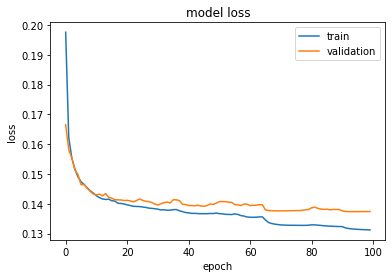

In [13]:
#Visualizing the Loss over epochs
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [33]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

In [26]:
# save model and architecture to single file
autoencoder.save("./pancan_meth_chr_blocks_ae_model.h5")
print("Saved model to disk")

# from keras.models import model_from_json
# ## Saving and Loading the Model
# # serialize model to JSON
# model_json = Model.to_json()
# with open("pancan_meth_chr_blocks_ae_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# Model.save_weights("pancan_meth_chr_blocks_ae_model.h5")
# print("Saved model to disk")
 
# # later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

Saved model to disk


In [29]:
from tensorflow import keras
temp_model = keras.models.load_model("./pancan_meth_chr_blocks_ae_model.h5")

ValueError: Unknown loss function: averaged_mean_squared_error. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [23]:
autoencoder

keras.engine.training.Model

In [31]:
#Obtain the reduced data
encoder = Model(inputs = input_dim_list, outputs = encoded3) ##ToDo: Vv sketchy
# encoded_input = Input(shape = (encoding_dim, ))

encoded_train = pd.DataFrame(encoder.predict(pancancer_meth_list), index=pancancer_meth_list[0].index) #Maintain Index for Mapping to cancer type 
encoded_train = encoded_train.add_prefix('feature_')
encoded_train.shape

(9756, 100)

In [42]:
#output dataset
shape_before_removing_nan = encoded_train.shape
encoded_train.replace(0, np.nan, inplace=True) #Converting all the zero's to nan to use nan command
encoded_train.dropna(how='all',axis=1, inplace=True) #Removing columns with all nan rows
encoded_train.dropna(how='all',axis=0, inplace=True) #Removing rows with all nan columns
encoded_train.replace(np.nan, 0, inplace=True) #Converting all the nan's to zero to be compatible with t-SNE
print(shape_before_removing_nan, encoded_train.shape)

encoded_train.to_csv("Meth_AE_chr_100.csv", index=True)
# encoded_train = pd.read_csv("Meth_AE_v2.csv",index_col=[0,1,2,3,4])

(9756, 54) (9756, 54)


In [41]:
encoded_train

,,,,,feature_3,feature_5,feature_6,feature_7,feature_9,feature_10,feature_12,feature_13,feature_14,feature_16,...,feature_82,feature_83,feature_85,feature_86,feature_88,feature_90,feature_93,feature_95,feature_98,feature_99
patient,sample,sample_type,aliquot,file,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J4,TCGA-OR-A5J4-01A,01A,TCGA-OR-A5J4-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0874f4b8-5743-4b41-9b99-f02186c8b51e\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J4-01A-11D-A29J-05.gdc_hg38_betaonly.txt,5.541511,0.000000,5.072050,0.0,2.666183,1.963223,0.0,0.163316,0.732340,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,4.148703,0.0,0.000000,0.006467
TCGA-OR-A5KO,TCGA-OR-A5KO-01A,01A,TCGA-OR-A5KO-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0885b557-48ca-4865-b17a-f2e1f6209b81\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5KO-01A-11D-A29J-05.gdc_hg38_betaonly.txt,7.366412,0.000000,3.835197,0.0,5.126200,2.377459,0.0,0.336157,3.125650,0.0,...,0.0,0.0,0.0,0.0,0.998013,0.000000,2.577299,0.0,1.874216,0.000000
TCGA-OR-A5J9,TCGA-OR-A5J9-01A,01A,TCGA-OR-A5J9-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\09eb5b05-2794-437b-a307-5255f69c4a32\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J9-01A-11D-A29J-05.gdc_hg38_betaonly.txt,4.120066,0.000000,2.073107,0.0,2.737824,0.959430,0.0,0.000000,2.024567,0.0,...,0.0,0.0,0.0,0.0,1.568415,0.000000,8.160261,0.0,0.748064,0.000000
TCGA-OR-A5K6,TCGA-OR-A5K6-01A,01A,TCGA-OR-A5K6-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\10ee4988-4a8f-4a0e-ae63-cc891c765fba\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5K6-01A-11D-A29J-05.gdc_hg38_betaonly.txt,3.627484,0.000000,1.425890,0.0,5.941448,2.042317,0.0,1.296161,2.161369,0.0,...,0.0,0.0,0.0,0.0,0.124631,0.000000,0.992546,0.0,4.918741,0.000000
TCGA-OR-A5JJ,TCGA-OR-A5JJ-01A,01A,TCGA-OR-A5JJ-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\16ff6c63-eca7-4376-a13e-682682b74e11\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5JJ-01A-11D-A29J-05.gdc_hg38_betaonly.txt,5.698373,0.000000,3.470033,0.0,3.833233,0.148585,0.0,0.000000,1.968729,0.0,...,0.0,0.0,0.0,0.0,2.923609,0.000000,3.191739,0.0,0.681116,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-V4-A9E5,TCGA-V4-A9E5-01A,01A,TCGA-V4-A9E5-01A-11D-A39X-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\uveal\f8414cb8-db02-4bff-acd7-4b9b1ebd38f1\jhu-usc.edu_UVM.HumanMethylation450.1.lvl-3.TCGA-V4-A9E5-01A-11D-A39X-05.gdc_hg38_betaonly.txt,6.872848,3.634715,0.449861,0.0,6.952518,4.216972,0.0,2.029853,4.185898,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,2.952181
TCGA-V4-A9EV,TCGA-V4-A9EV-01A,01A,TCGA-V4-A9EV-01A-11D-A39X-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\uveal\f8e48da2-45f8-4b5a-af88-5e8476da49bd\jhu-usc.edu_UVM.HumanMethylation450.1.lvl-3.TCGA-V4-A9EV-01A-11D-A39X-05.gdc_hg38_betaonly.txt,2.277284,4.098686,0.126937,0.0,2.680127,2.427616,0.0,0.615677,2.120171,0.0,...,0.0,0.0,0.0,0.0,2.210240,0.000000,0.000000,0.0,0.000000,0.000000
TCGA-WC-AA9A,TCGA-WC-AA9A-01A,01A,TCGA-WC-AA9A-01A-11D-A39X-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\uveal\fcac5928-4262-47c9-8654-3ec1794f688f\jhu-usc.edu_UVM.HumanMethylation450.1.lvl-3.TCGA-WC-AA9A-01A-11D-A39X-05.gdc_hg38_betaonly.txt,4.016893,3.966357,0.000000,0.0,5.188296,0.000000,0.0,0.739484,2.719020,0.0,...,0.0,0.0,0.0,0.0,1.564690,0.000000,1.874074,0.0,0.000000,0.000000


In [ ]:
# encoded_train.to_csv("Meth_AE_v2.csv", index=True)
# encoded_train = pd.read_csv("Meth_AE_v2.csv",index_col=[0,1,2,3,4])

In [16]:
#Scaling these features to -1,1 range for applying tsne
from sklearn.preprocessing import MinMaxScaler
feature_list = encoded_train.columns.tolist()
scaler = MinMaxScaler(feature_range=(0,1))
encoded_train[feature_list] = scaler.fit_transform(encoded_train[feature_list])

In [17]:
encoded_train.head()

,,,,,feature_3,feature_5,feature_6,feature_7,feature_9,feature_10,feature_12,feature_13,feature_14,feature_16,...,feature_82,feature_83,feature_85,feature_86,feature_88,feature_90,feature_93,feature_95,feature_98,feature_99
patient,sample,sample_type,aliquot,file,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J4,TCGA-OR-A5J4-01A,01A,TCGA-OR-A5J4-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0874f4b8-5743-4b41-9b99-f02186c8b51e\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J4-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.650172,0.0,0.559180,0.0,0.309088,0.298732,0.0,0.022142,0.098069,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.266402,0.0,0.000000,0.000852
TCGA-OR-A5KO,TCGA-OR-A5KO-01A,01A,TCGA-OR-A5KO-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0885b557-48ca-4865-b17a-f2e1f6209b81\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5KO-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.864284,0.0,0.422820,0.0,0.594276,0.361763,0.0,0.045576,0.418562,0.0,...,0.0,0.0,0.0,0.0,0.136887,0.0,0.165497,0.0,0.248414,0.000000
TCGA-OR-A5J9,TCGA-OR-A5J9-01A,01A,TCGA-OR-A5J9-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\09eb5b05-2794-437b-a307-5255f69c4a32\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J9-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.483398,0.0,0.228555,0.0,0.317394,0.145991,0.0,0.000000,0.271114,0.0,...,0.0,0.0,0.0,0.0,0.215123,0.0,0.523997,0.0,0.099151,0.000000
TCGA-OR-A5K6,TCGA-OR-A5K6-01A,01A,TCGA-OR-A5K6-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\10ee4988-4a8f-4a0e-ae63-cc891c765fba\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5K6-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.425604,0.0,0.157201,0.0,0.688787,0.310767,0.0,0.175732,0.289434,0.0,...,0.0,0.0,0.0,0.0,0.017094,0.0,0.063735,0.0,0.651944,0.000000
TCGA-OR-A5JJ,TCGA-OR-A5JJ-01A,01A,TCGA-OR-A5JJ-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\16ff6c63-eca7-4376-a13e-682682b74e11\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5JJ-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.668577,0.0,0.382562,0.0,0.444384,0.022609,0.0,0.000000,0.263637,0.0,...,0.0,0.0,0.0,0.0,0.401000,0.0,0.204952,0.0,0.090277,0.000000


### 6. Dimension Reduction and Cluster Visualization using t-SNE 


perplexity parameter can be changed based on the input datatset - dataset with larger number of variables requires larger perplexity set this value between 5 and 50 (sklearn documentation) verbose=1 displays run time messages set n_iter sufficiently high to resolve the well stabilized cluster get embeddings


In [18]:
# Perform t-SNE on AE encoded_features
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=40, learning_rate=300, n_iter=400, verbose=1)
tsne_out = tsne.fit_transform(encoded_train)
# tsne_out = TSNE(n_components=2, perplexity=105, n_iter=1000, verbose=1).fit_transform(encoded_train)
tsne_components = pd.DataFrame(tsne_out, index =encoded_train.index ) #Maintain Index


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9756 samples in 0.000s...
[t-SNE] Computed neighbors for 9756 samples in 2.526s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9756
[t-SNE] Computed conditional probabilities for sample 2000 / 9756
[t-SNE] Computed conditional probabilities for sample 3000 / 9756
[t-SNE] Computed conditional probabilities for sample 4000 / 9756
[t-SNE] Computed conditional probabilities for sample 5000 / 9756
[t-SNE] Computed conditional probabilities for sample 6000 / 9756
[t-SNE] Computed conditional probabilities for sample 7000 / 9756
[t-SNE] Computed conditional probabilities for sample 8000 / 9756
[t-SNE] Computed conditional probabilities for sample 9000 / 9756
[t-SNE] Computed conditional probabilities for sample 9756 / 9756
[t-SNE] Mean sigma: 0.215720


C:\Users\ssrikrishnan6\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.724152
[t-SNE] KL divergence after 400 iterations: 1.548146


In [19]:
tsne_components = pd.DataFrame(tsne_out, index =encoded_train.index ) #Maintain Index
tsne_components.head()

,,,,,0,1
patient,sample,sample_type,aliquot,file,,
TCGA-OR-A5J4,TCGA-OR-A5J4-01A,01A,TCGA-OR-A5J4-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0874f4b8-5743-4b41-9b99-f02186c8b51e\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J4-01A-11D-A29J-05.gdc_hg38_betaonly.txt,-9.774884,8.958895
TCGA-OR-A5KO,TCGA-OR-A5KO-01A,01A,TCGA-OR-A5KO-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0885b557-48ca-4865-b17a-f2e1f6209b81\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5KO-01A-11D-A29J-05.gdc_hg38_betaonly.txt,-10.576678,7.780422
TCGA-OR-A5J9,TCGA-OR-A5J9-01A,01A,TCGA-OR-A5J9-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\09eb5b05-2794-437b-a307-5255f69c4a32\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J9-01A-11D-A29J-05.gdc_hg38_betaonly.txt,-9.351511,8.142668
TCGA-OR-A5K6,TCGA-OR-A5K6-01A,01A,TCGA-OR-A5K6-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\10ee4988-4a8f-4a0e-ae63-cc891c765fba\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5K6-01A-11D-A29J-05.gdc_hg38_betaonly.txt,-11.087436,7.063640
TCGA-OR-A5JJ,TCGA-OR-A5JJ-01A,01A,TCGA-OR-A5JJ-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\16ff6c63-eca7-4376-a13e-682682b74e11\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5JJ-01A-11D-A29J-05.gdc_hg38_betaonly.txt,-9.819505,8.192178


### 7. Mapping samples to cancer type


In [20]:
import pandas as pd
patient_metadata = pd.read_csv(r"C:\Users\ssrikrishnan6\ae_integration\info_all_ex.txt", sep = "\t")
patient_metadata = patient_metadata[[ 'cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id','cases.0.project.project_id','cases.0.samples.0.sample_type']] #tolist()
patient_metadata.rename(columns={'cases.0.project.project_id': "cancer_type", "cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id":"tcga_id"},inplace=True)
patient_metadata.set_index("tcga_id", inplace=True)

new_patient_indices = []
for index in patient_metadata.index:
    new_patient_indices.append("-".join(index.split("-")[:-3]))
patient_metadata.index = new_patient_indices

In [32]:
patient_metadata.index 

Index(['TCGA-NC-A5HI-01A', 'TCGA-68-8251-01A', 'TCGA-98-A53A-01A',
       'TCGA-39-5029-01A', 'TCGA-22-5474-01A', 'TCGA-CN-5355-01A',
       'TCGA-CV-7235-01A', 'TCGA-CV-5440-01A', 'TCGA-MT-A51X-01A',
       'TCGA-CQ-5331-01A',
       ...
       'TCGA-CH-5740-01A', 'TCGA-J4-A67M-01A', 'TCGA-M7-A723-01A',
       'TCGA-HC-7075-01A', 'TCGA-CH-5741-01A', 'TCGA-YL-A9WL-01A',
       'TCGA-KK-A5A1-01A', 'TCGA-HU-A4H6-01A', 'TCGA-BR-8291-01A',
       'TCGA-BR-4253-01A'],
      dtype='object', length=11093)

In [35]:
new_indices = []
for index in tsne_components.index:
    new_index = index[1]
    new_indices.append(new_index)
tsne_components.index = new_indices

# new_tsne_components = tsne_components.copy()
# new_tsne_components.index = new_indices

# #Merging based on tcga_id
grouped_tsne = pd.merge(tsne_components , patient_metadata['cancer_type'] , left_index=True, right_index=True)

print(grouped_tsne.shape)
grouped_tsne.head()

(9151, 3)


,0,1,cancer_type
TCGA-05-4384-01A,14.167734,-11.823607,TCGA-LUAD
TCGA-05-4390-01A,14.970627,-13.676927,TCGA-LUAD
TCGA-05-4396-01A,13.620174,-13.718046,TCGA-LUAD
TCGA-05-4405-01A,9.500464,-12.058088,TCGA-LUAD
TCGA-05-4410-01A,11.911108,-11.166135,TCGA-LUAD


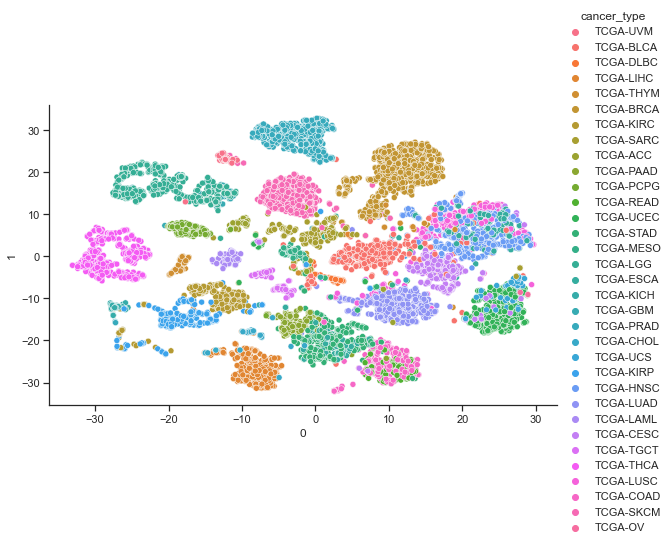

In [36]:
# CURRENT
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks')

cancer_types = grouped_tsne['cancer_type'].tolist()
cancer_types = list(set(cancer_types))

seaborn.relplot(data=grouped_tsne, x=0, y=1, hue='cancer_type', hue_order=cancer_types, aspect=1.61)
plt.show()

Relplot = A figure-level function for visualizing statistical relationships using two common approaches: scatter plots and line plots. relplot() combines a FacetGrid with one of two axes-level functions: scatterplot() (with kind="scatter" ; the default)

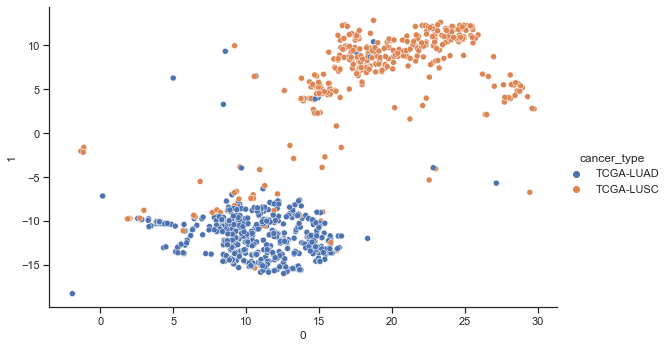

In [37]:
lung_cancer_types = ["TCGA-LUAD","TCGA-LUSC"] 
lung_cancer_df = grouped_tsne[grouped_tsne['cancer_type'].isin(lung_cancer_types)]

seaborn.relplot(data=lung_cancer_df, x=0, y=1, hue='cancer_type', hue_order=lung_cancer_types, aspect=1.61)
plt.show()

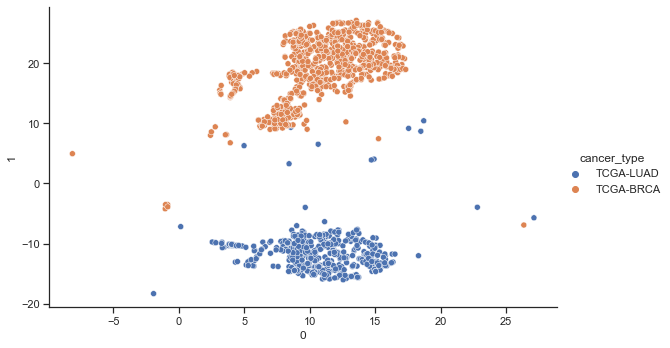

In [38]:
lung_breast_cancer_types = ["TCGA-LUAD","TCGA-BRCA"] 
lung_breast_cancer_df = grouped_tsne[grouped_tsne['cancer_type'].isin(lung_breast_cancer_types)]

seaborn.relplot(data=lung_breast_cancer_df, x=0, y=1, hue='cancer_type', hue_order=lung_breast_cancer_types, aspect=1.61)
plt.show()

In [3]:
# import os
# print (os.environ['CONDA_DEFAULT_ENV'])

tf_gpu
